In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt
import scipy.ndimage
from cv2 import imread
import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [2]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [3]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [4]:
def get_cameraman_tensor(sidelength):
    img = Image.fromarray(skimage.data.camera())        
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

def get_brick_tensor(sidelength):
    img = Image.fromarray(skimage.data.brick())        
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

In [5]:
class CompositeGradients(Dataset):
    def __init__(self, img_filepath1, img_filepath2,
                 sidelength=None,
                 is_color=False):
        super().__init__()

        #if isinstance(sidelength, int):
          #  sidelength = (sidelength, sidelength)

        self.is_color = is_color
        if (self.is_color):
            self.channels = 3
        else:
            self.channels = 1

        self.img1 = Image.open(img_filepath1)
        self.img2 = Image.open(img_filepath2)

        if not self.is_color:
            self.img1 = self.img1.convert("L")
            self.img2 = self.img2.convert("L")
        else:
            self.img1 = self.img1.convert("RGB")
            self.img2 = self.img2.convert("RGB")

        self.transform = Compose([
            ToTensor(),
            Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
        ])
        self.img1 = self.img1.resize((sidelength, sidelength))
        self.img2 = self.img2.resize((sidelength, sidelength))
        
        self.mgrid = get_mgrid(int(sidelength),2)

        self.img1 = self.transform(self.img1)
        self.img2 = self.transform(self.img2)

        paddedImg = .85 * torch.ones_like(self.img1)

        paddedImg[:, self.img1.shape[1] - self.img2.shape[1]:self.img1.shape[1], :] = self.img2
        self.img2 = paddedImg

        self.grads1 = self.compute_gradients(self.img1)
        self.grads2 = self.compute_gradients(self.img2)

        self.comp_grads = (.5 * self.grads1 + .5 * self.grads2)

        self.img1 = self.img1.permute(1, 2, 0).view(-1, self.channels)
        self.img2 = self.img2.permute(1, 2, 0).view(-1, self.channels)

    def compute_gradients(self, img):
        if not self.is_color:
            gradx = scipy.ndimage.sobel(img.numpy(), axis=1).squeeze(0)[..., None]
            grady = scipy.ndimage.sobel(img.numpy(), axis=2).squeeze(0)[..., None]
        else:
            gradx = np.moveaxis(scipy.ndimage.sobel(img.numpy(), axis=1), 0, -1)
            grady = np.moveaxis(scipy.ndimage.sobel(img.numpy(), axis=2), 0, -1)

        grads = torch.cat((torch.from_numpy(gradx).reshape(-1, self.channels),
                           torch.from_numpy(grady).reshape(-1, self.channels)),
                          dim=-1)
        return grads

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        in_dict = {'idx': idx, 'pixels': self.mgrid}
        gt_dict = {'img1': self.img1,
                   'img2': self.img2,
                   'grads1': self.grads1,
                   'grads2': self.grads2,
                   'grads': self.comp_grads}

        return in_dict['pixels'], gt_dict

In [6]:

    
class PoissonCustomEqn(Dataset):
    def __init__(self, sidelength, path_1, path_2):
        super().__init__()
        img_1 = get_img_tensor(path_1,sidelength)
        img_2 = get_img_tensor(path_2,int(sidelength/2))
        print(img_1.numpy().shape)
        print(img_2.numpy().shape)
        
        # Compute gradient and laplacian
        grads_x = scipy.ndimage.sobel(img.numpy(), axis=1).squeeze(0)[..., None]
        grads_y = scipy.ndimage.sobel(img.numpy(), axis=2).squeeze(0)[..., None]
        grads_x, grads_y = torch.from_numpy(grads_x), torch.from_numpy(grads_y)
                
        self.grads = torch.stack((grads_x, grads_y), dim=-1).view(-1, 2)
        self.laplace = scipy.ndimage.laplace(img_1.numpy()).squeeze(0)[..., None]
        self.laplace = torch.from_numpy(self.laplace)
        
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.coords, {'pixels':self.pixels, 'grads':self.grads, 'laplace':self.laplace}

In [7]:
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_cameraman_tensor(sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

In [11]:
cameraman_poisson = CompositeGradients('room.jpg','sofa.jpg',is_color=False, sidelength=128)
dataloader = DataLoader(cameraman_poisson, batch_size=1, pin_memory=True, num_workers=0)

poisson_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
                      hidden_layers=3, outermost_linear=True)


(1, 128, 128)
(1, 128, 128)


In [12]:
def gradients_mse(model_output, coords, gt_gradients, model=None):
    # compute gradients on the model
    gradients = gradient(model_output, coords)
    # compare them with the ground-truth
    gradients_loss = torch.mean((gradients - gt_gradients).pow(2).sum(-1))
    return gradients_loss

Step 0, Total loss 0.002333, iteration time 0.224050


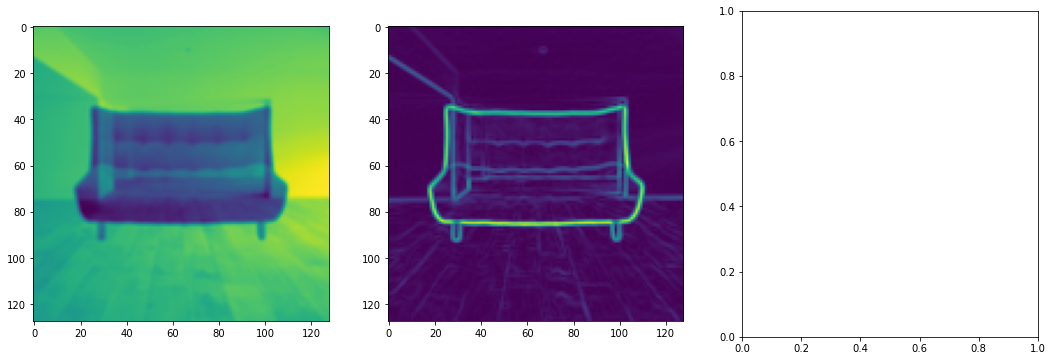

Step 200, Total loss 0.002083, iteration time 0.215047


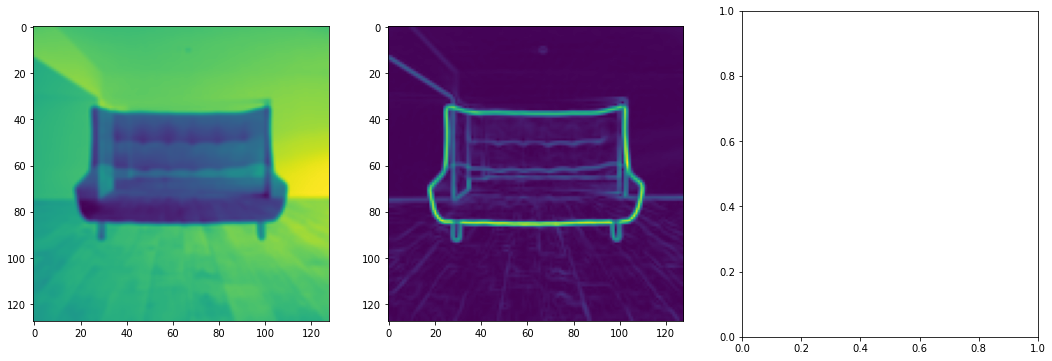

Step 400, Total loss 0.015170, iteration time 0.226051


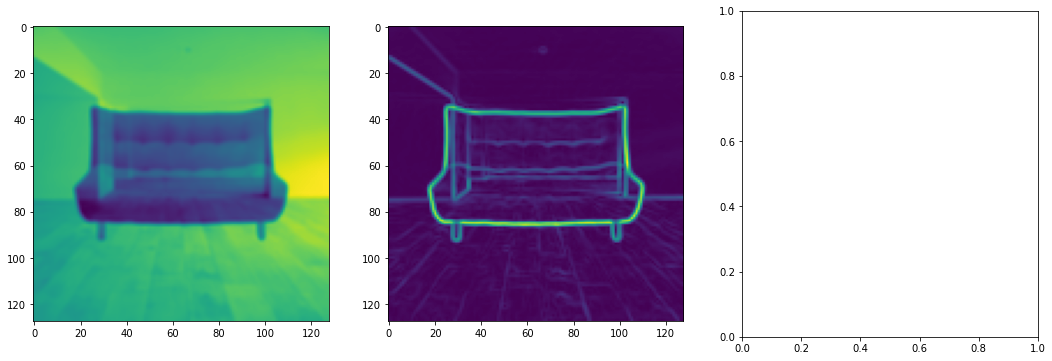

Step 600, Total loss 0.001271, iteration time 0.225051


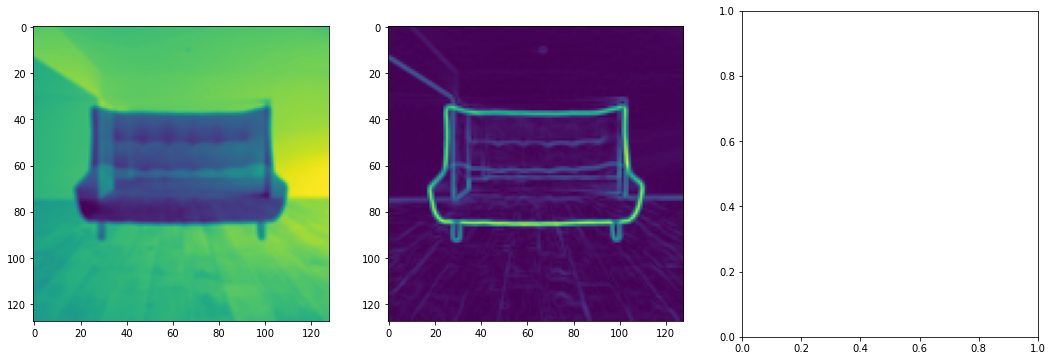

Step 800, Total loss 0.001460, iteration time 0.215047


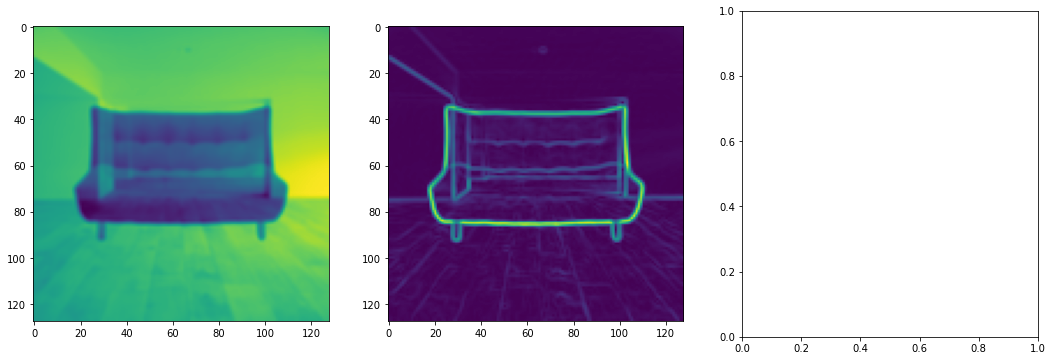

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [256, 1]], which is output 0 of TBackward, is at version 1502; expected version 1501 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [14]:
total_steps = 1000
steps_til_summary = 200

optim = torch.optim.Adam(lr=1e-4, params=poisson_siren.parameters())

model_input, gt = next(iter(dataloader))
gt = {key: value.cpu() for key, value in gt.items()}

for step in range(total_steps):
    start_time = time.time()

    model_output, coords = poisson_siren(model_input)
    train_loss = gradients_mse(model_output, coords, gt['grads'])

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f, iteration time %0.6f" % (step, train_loss, time.time() - start_time))
        img_grad = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].imshow(model_output.cpu().view(128,128).detach().numpy())
        axes[1].imshow(img_grad.cpu().norm(dim=-1).view(128,128).detach().numpy())
        #axes[2].imshow(img_laplacian.cpu().view(128,128).detach().numpy())
        plt.show()
    optim.zero_grad()
    train_loss.backward()
    optim.step()

img_grad = gradient(model_output, coords)
img_laplacian = laplace(model_output, coords)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(model_output.cpu().view(128,128).detach().numpy())
axes[1].imshow(img_grad.cpu().norm(dim=-1).view(128,128).detach().numpy())
axes[2].imshow(img_laplacian.cpu().view(128,128).detach().numpy())
plt.show()